![Image of Yaktocat](https://storage.googleapis.com/kaggle-competitions/kaggle/7327/logos/header.png)

# Dog Breed Identification - Part 3 - Transfer Learning

I decided to chose the Xception trained model architecture from Keras. 

Xception is an extension of the Inception architecture which replaces the standard Inception modules with depthwise separable convolutions.
Xception sports the smallest weight serialization at only 91MB (vgg16/19 have weights are > 500MB). This is a huge benefit as we have limited computing resources at hand. 
Xception require 299×299 pixel inputs.

After a couple of runs I decided to add GlobalAveragePooling, Dropout and Dense (fully connected) Layers.

-Global average pooling replaces the traditional fully connected layers in CNN. The idea is to generate one feature map for each corresponding category of classification task in the last convolutional layer.<br>
Instead of adding fully connected layers on top of the feature maps, we take the average of each feature map, and the resulting vector is fed directly into the softmax layer. 
It treats the convolutional layers as feature extractors, and the resulting feature is classified in a traditional way. 
Advantages:
There is no parameter to optimize in the global average pooling thus overfitting is avoided at this layer. 
It is also more native to the convolution structure by enforcing correspondences between feature maps and categories.

-Dropout is a technique used to improve over-fit on neural networks.
The use of dropout also make the training loss error a little worse. But that's the idea, basically we want to trade training performance for more generalization.
Normally we would like to use Dropout on the fully connected layers, but is also possible to use dropout after the average/max-pooling layers, creating some kind of image noise augmentation.

-Dense (fully connected) layers perform classification on the features, extracted by the convolutional layers, and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.

As Xception was trained with images of size 299x299, we will resize the Dataset and will convert all the images to that size.<br>
I chose to use the same augmenation as in Part 2 since we have been working here with the same Dataset and saw that it improved the results. 

# Creating a New Model:

In [79]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input
from keras.preprocessing import image
from keras.applications import xception


# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(120, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [80]:
from Scripts.clr_callback import CyclicLR

import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard

from time import gmtime, strftime


# checkpoints
early_stopping = EarlyStopping(monitor='val_acc', patience=10)
time = strftime("%Y.%m.%d.%H%M%S", gmtime())


# model_checkpoint = ModelCheckpoint(bst_model_path,
#                                    save_best_only=True,
#                                    save_weights_only=True)

checkpointer = ModelCheckpoint(filepath=f'saved_models/{time}_dog_breed_model.hdf5', 
                               verbose=1, 
                               save_best_only=True,
                               monitor='val_acc'
                              )

tensor_board = TensorBoard(f'./logs/DogBreedAnn{time}')

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
step_size = 2000
clr = CyclicLR(base_lr=0.0001,
               max_lr=0.001,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)


In [81]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

# Fitting the new model:

In [82]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

train_data_dir = 'C:/DogBreedDataSet/train'
validation_data_dir = 'C:/DogBreedDataSet/valid'
# dimensions of our images.
img_width, img_height = 299,299
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function = preprocess_input
)

# for validation we will use only rescaling
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

# min sd for normalising

# creating dataGenerator for our training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size)

# creating dataGenerator for our validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.


In [16]:
nb_train_samples = 8178
nb_validation_samples = 2044
epochs = 50

# train the model on the new data for a few epochs
# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,early_stopping, checkpointer, clr],
    verbose=1
)   



Epoch 1/50
511/511 [==============================] - 627s 1s/step - loss: 2.7496 - acc: 0.4075 - val_loss: 0.5679 - val_acc: 0.8297

Epoch 00001: val_acc improved from -inf to 0.82972, saving model to saved_models/2018.11.23.225348_dog_breed_model.hdf5
Epoch 2/50
511/511 [==============================] - 622s 1s/step - loss: 1.1000 - acc: 0.6974 - val_loss: 0.4600 - val_acc: 0.8516

Epoch 00002: val_acc improved from 0.82972 to 0.85158, saving model to saved_models/2018.11.23.225348_dog_breed_model.hdf5
Epoch 3/50
511/511 [==============================] - 621s 1s/step - loss: 1.0899 - acc: 0.7204 - val_loss: 0.5321 - val_acc: 0.8323

Epoch 00003: val_acc did not improve from 0.85158
Epoch 4/50
511/511 [==============================] - 621s 1s/step - loss: 1.1536 - acc: 0.7162 - val_loss: 0.5304 - val_acc: 0.8437

Epoch 00004: val_acc did not improve from 0.85158
Epoch 5/50
511/511 [==============================] - 622s 1s/step - loss: 1.1474 - acc: 0.7334 - val_loss: 0.4807 - val_


Epoch 00042: val_acc did not improve from 0.86686


In [84]:
# creating dataGenerator for our validation data
test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode= None)

#loading the model
model.load_weights('saved_models/2018.11.23.225348_dog_breed_model.hdf5')

predictions = model.predict_generator(test_generator, (nb_validation_samples // batch_size+1) )

Found 2044 images belonging to 120 classes.


## Analysis of predictions:

Lets gather some metrics and analyse it

In [117]:
from sklearn.metrics import classification_report, confusion_matrix

import os
import seaborn as sns
import matplotlib.pyplot as plt

ClassPredictions = predictions.argmax(axis=-1) 
conf = confusion_matrix(test_generator.classes, ClassPredictions)

target_names = os.listdir('../DogBreedDataSet/valid/')
target_names.sort()



print(classification_report(test_generator.classes, ClassPredictions, target_names=target_names))


                                precision    recall  f1-score   support

                 affenpinscher       1.00      0.88      0.94        17
                  afghan_hound       0.94      0.94      0.94        17
           african_hunting_dog       1.00      0.88      0.94        17
                      airedale       0.86      0.71      0.77        17
american_staffordshire_terrier       0.71      0.59      0.65        17
                   appenzeller       0.75      0.71      0.73        17
            australian_terrier       0.70      0.94      0.80        17
                       basenji       1.00      0.94      0.97        17
                        basset       0.89      1.00      0.94        17
                        beagle       0.87      0.76      0.81        17
            bedlington_terrier       0.94      1.00      0.97        17
          bernese_mountain_dog       0.77      1.00      0.87        17
       black-and-tan_coonhound       0.94      0.88      0.91  

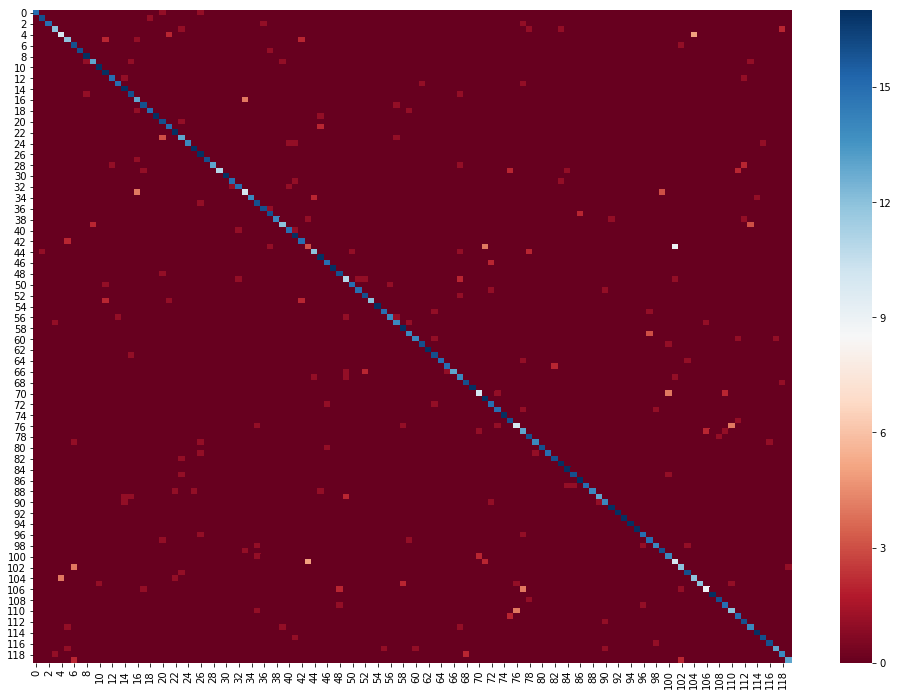

In [89]:
plt.figure(figsize=(17,12))
sns.heatmap(data = conf,cmap='RdBu')

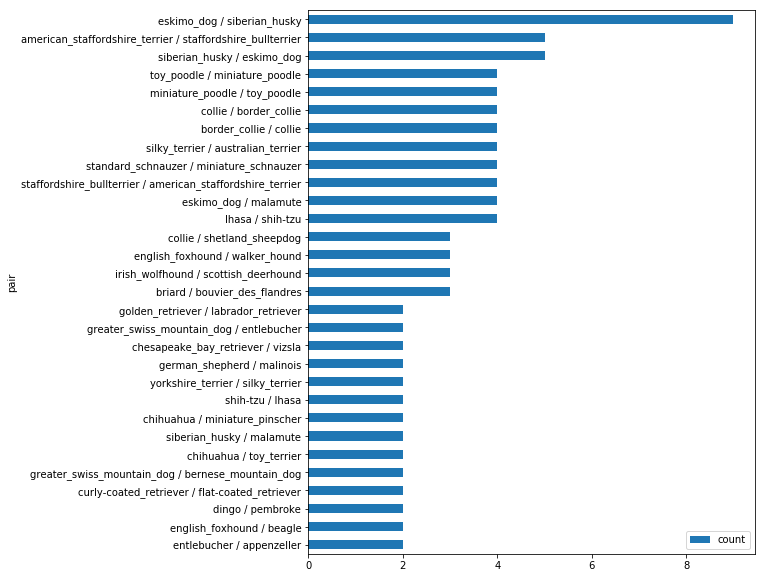

In [118]:
import pandas as pd

labelNames = [target_names[x] for x in test_generator.classes]
ClassPredictionsNames = [target_names[x] for x in ClassPredictions]

d = {'actual':labelNames , 'pred':ClassPredictionsNames}
df = pd.DataFrame(d)

df['count'] = 1

misclass_df = df[df['actual'] != df['pred']].groupby(['actual', 'pred']).sum().sort_values(['count'], ascending=False).reset_index()

misclass_df['pair'] = misclass_df['actual'].astype(str) + ' / ' + misclass_df['pred'].astype(str)

misclass_df = misclass_df[['pair', 'count']].take(range(30))

misclass_df.sort_values(['count']).plot.barh(figsize=(8, 10), x='pair')

The largest mismatch is between Siberian Husky and Eskimo Dog and the seccond biggest mismatch is between American Staffordshire Terrier and Staffordshire Bullterier.

Both of the mismatches are between very similar breeds, we expect a human to misclassify them as well and have precision rate of 50%.

Another interesting key here is that the model, is having more mistakes of eskimo as husky then the opposite, this is probably due to the imbalance we have in our data as husky class has more samples than eskimo

## Siberian Husky:

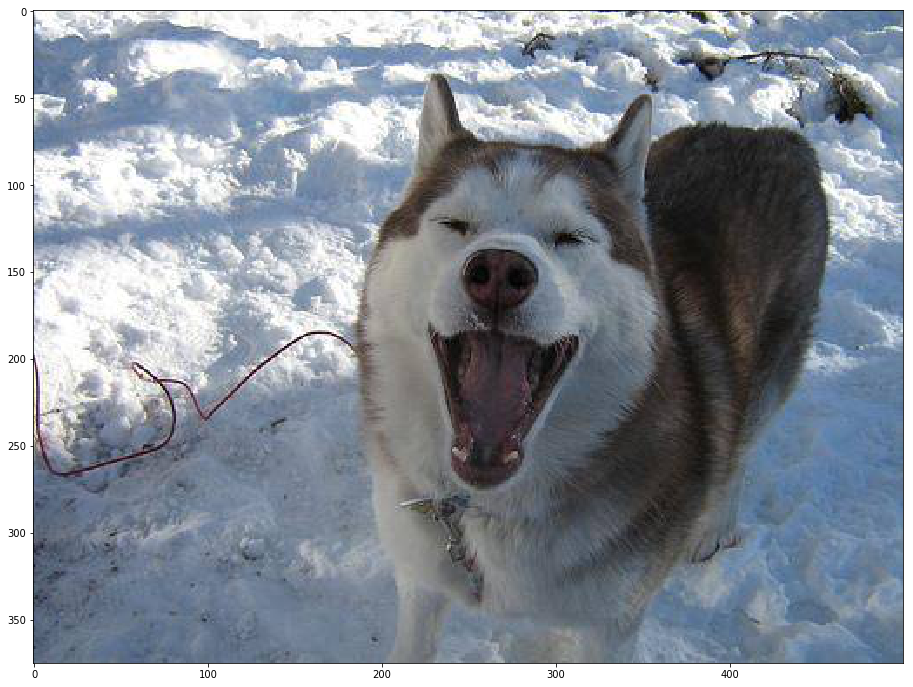

In [10]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/siberian_husky/7972d0467f6a8d6f209f948347061e24.jpg')
imgplot = plt.imshow(img)
plt.show()


## Eskimo Dog:

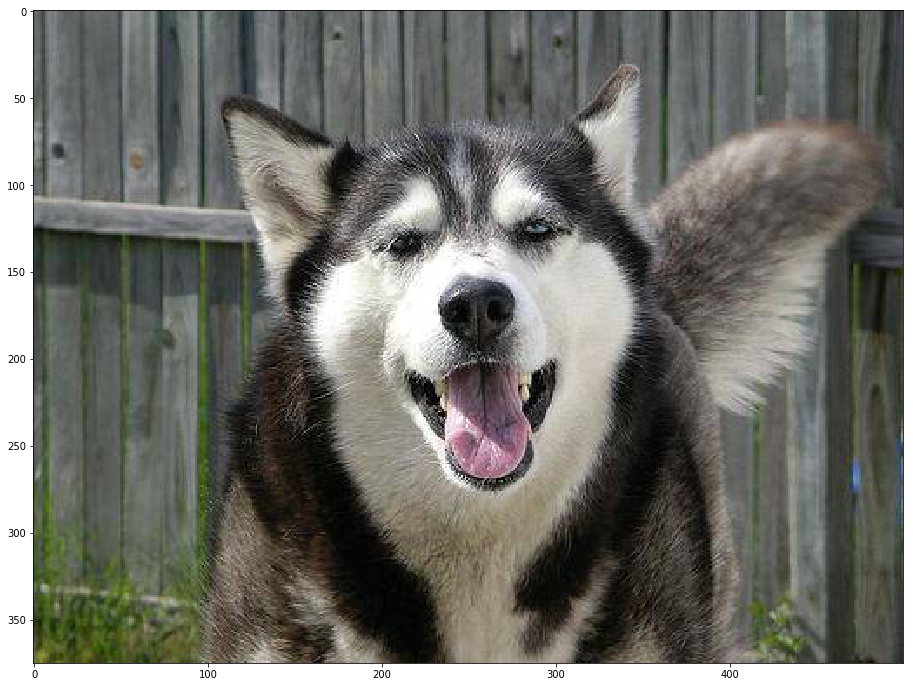

In [11]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/eskimo_dog/c9579c8fd920a1e698c696168946a83b.jpg')
imgplot = plt.imshow(img)
plt.show()


## American Staffordshire Terrier:

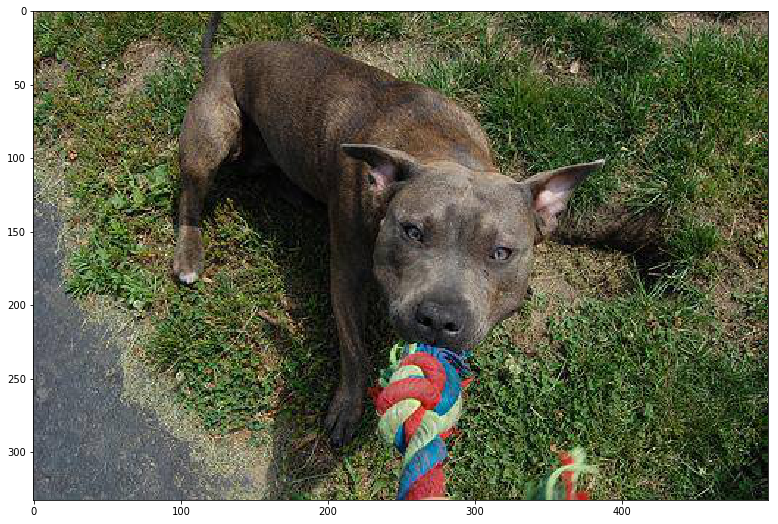

In [28]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/american_staffordshire_terrier/29bea12d15de7705ddc0e2d1d8c95f6b.jpg')
imgplot = plt.imshow(img)
plt.show()


## Staffordshire Bullterier:

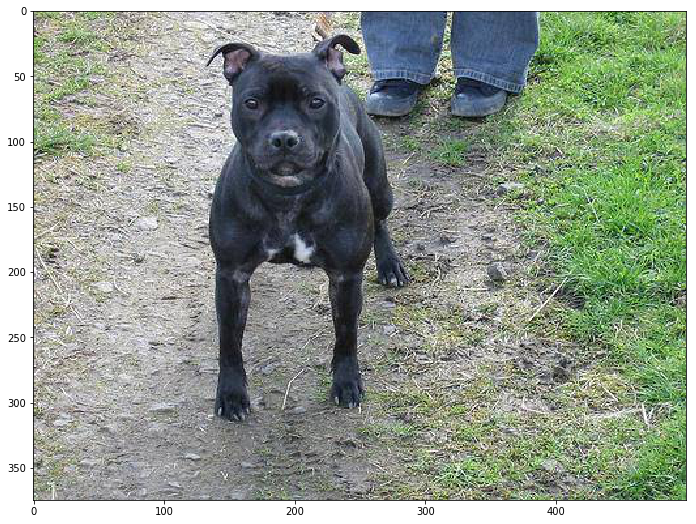

In [29]:
plt.figure(figsize=(16,9))
img=mpimg.imread('../DogBreedDataSet/train/staffordshire_bullterrier/4b9ce080f420698deda6df4fd82240f4.jpg')
imgplot = plt.imshow(img)
plt.show()


## Extracting features:

I decided to use the simplest Logistic Regression Machine Learning algorithm. Logistic regression is one of the most famous machine learning algorithms. The use of logistic regression is for classification tasks, which is exactly our task.
We are using the previous trained model as a feature extractor; we omit the last layer, and then use predicted values as features for Logistic regression algorithm.

At the end of the document there are our tries with other ML algorithm which gave worse results

In [31]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input
from keras.preprocessing import image
from keras.applications import xception


# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)

# make average pooling layer
x = base_model.output

# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = GlobalAveragePooling2D()(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [32]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

train_data_dir = '../DogBreedDataSet/train'
validation_data_dir = '../DogBreedDataSet/valid'
# dimensions of our images.
img_width, img_height = 299,299
batch_size = 16
nb_train_samples = 8178
nb_validation_samples = 2044

# freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
           metrics=["accuracy"])

# for validation we will use only preproccesing of xception
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)


# creating dataGenerator for our training data
MLTrain_generator = test_datagen.flow_from_directory(
    train_data_dir,
    shuffle=False,
    class_mode=None,
    target_size=(img_width, img_height),
    batch_size=1)

MLTest_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    class_mode=None,
    target_size=(img_width, img_height),
    batch_size=1)

Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.


In [33]:
MLTrain_generator.reset()
trainFeatures = model.predict_generator(MLTrain_generator, nb_train_samples )

MLTest_generator.reset()
validFeatures = model.predict_generator(MLTest_generator, nb_validation_samples )

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

logisticRegression = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logisticRegression.fit(trainFeatures, MLTrain_generator.classes)

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [55]:
ClassPredictions = logisticRegression.predict(validFeatures)
ClasProba = logisticRegression.predict_proba(validFeatures)

target_names = os.listdir('../DogBreedDataSet/valid/')
target_names.sort()

print('LogLoss {}'.format(log_loss(MLTest_generator.classes, ClasProba)))
print(classification_report(MLTest_generator.classes, ClassPredictions, target_names=target_names))

Validation LogLoss 0.3611394068577661
                                precision    recall  f1-score   support

                 affenpinscher       1.00      0.88      0.94        17
                  afghan_hound       1.00      0.94      0.97        17
           african_hunting_dog       1.00      0.88      0.94        17
                      airedale       0.94      0.94      0.94        17
american_staffordshire_terrier       0.61      0.65      0.63        17
                   appenzeller       0.75      0.71      0.73        17
            australian_terrier       0.82      0.82      0.82        17
                       basenji       1.00      1.00      1.00        17
                        basset       0.94      0.94      0.94        17
                        beagle       0.88      0.82      0.85        17
            bedlington_terrier       1.00      1.00      1.00        17
          bernese_mountain_dog       0.81      1.00      0.89        17
       black-and-tan_coon

We got weighted avg of 90%! a 3% improvement, even without sophisticated hyperparameter tuning, and a very good score for the limited resources we have.


## Best For Last (sorry not really)

Another promising approach was to train our model with variety of image size from small to big instead of fixing all of them to one size.

The idea behind this method is to teach our model the big drastic features between dog breeds, and then continue learning the more gentle features on bigger pictures.

In [3]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input
from keras.preprocessing import image
from keras.applications import xception
from keras.applications.xception import preprocess_input

# base model as xception
base_model = xception.Xception(weights='imagenet', include_top=False)

x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
# softmax layer for predictions
predictions = Dense(120, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)



In [4]:
from Scripts.clr_callback import CyclicLR
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
from time import gmtime, strftime

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

time = strftime("%Y.%m.%d.%H%M%S", gmtime())

savedModelFilepath=f'saved_models/{time}_dog_breed_modelSmallToBig.hdf5'

checkpointer = ModelCheckpoint(filepath=savedModelFilepath, 
                               verbose=1, 
                               save_best_only=True,
                               monitor='val_loss'
                              )

tensor_board = TensorBoard(f'./logs/DogBreedAnnSmallToBig{time}')

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
step_size = 2000
clr = CyclicLR(base_lr=0.0001,
               max_lr=0.001,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)


In [5]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

# Fitting the new model:

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'C:/DogBreedDataSet/train'
validation_data_dir = 'C:/DogBreedDataSet/valid'
# dimensions of our images.
img_width, img_height = 128,128
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function = preprocess_input
)

# for validation we will use only preproccesing of xception
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

# creating dataGenerator for our training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size)

# creating dataGenerator for our validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')





Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.


## Training on image size 128X128

In [7]:
nb_train_samples = 8178
nb_validation_samples = 2044
epochs = 50

# train the model on the new data for a few epochs
# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,early_stopping, checkpointer, clr],
    verbose=1
)   



Epoch 1/50
511/511 [==============================] - 131s 257ms/step - loss: 5.4793 - acc: 0.0142 - val_loss: 5.1597 - val_acc: 0.1329

Epoch 00001: val_loss improved from inf to 5.15971, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 2/50
511/511 [==============================] - 127s 249ms/step - loss: 4.9551 - acc: 0.0428 - val_loss: 5.1925 - val_acc: 0.2539

Epoch 00002: val_loss did not improve from 5.15971
Epoch 3/50
511/511 [==============================] - 126s 247ms/step - loss: 4.5901 - acc: 0.0826 - val_loss: 4.8034 - val_acc: 0.3131

Epoch 00003: val_loss improved from 5.15971 to 4.80335, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 4/50
511/511 [==============================] - 126s 247ms/step - loss: 4.3326 - acc: 0.0992 - val_loss: 5.5007 - val_acc: 0.3343

Epoch 00004: val_loss did not improve from 4.80335
Epoch 5/50
511/511 [==============================] - 126s 246ms/step - loss: 4.2253 -

We see here that after a couple of epochs the model stops learing new features and start memorizing the dataset and overfit to it

## Continue Training on image size 256X256

In [8]:
img_width, img_height = 256,256
epochs = 50

#loading the model from the best weight in last run
model.load_weights(savedModelFilepath)

#re configuring all callbacks
clr = CyclicLR(base_lr=0.0001,
               max_lr=0.001,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

checkpointer = ModelCheckpoint(filepath=savedModelFilepath, 
                               verbose=1, 
                               save_best_only=True,
                               monitor='val_loss'
                              )

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# creating dataGenerator for our training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size)

# creating dataGenerator for our validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# train the model on the new data for a few epochs
# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,early_stopping, checkpointer, clr],
    verbose=1
)   

Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.
Epoch 1/50
511/511 [==============================] - 438s 857ms/step - loss: 2.8336 - acc: 0.3231 - val_loss: 1.0278 - val_acc: 0.7131

Epoch 00001: val_loss improved from inf to 1.02777, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 2/50
511/511 [==============================] - 437s 856ms/step - loss: 2.1169 - acc: 0.4547 - val_loss: 0.8744 - val_acc: 0.7687

Epoch 00002: val_loss improved from 1.02777 to 0.87442, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 3/50
511/511 [==============================] - 435s 852ms/step - loss: 1.9192 - acc: 0.5078 - val_loss: 0.8682 - val_acc: 0.7791

Epoch 00003: val_loss improved from 0.87442 to 0.86818, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 4/50
511/511 [==============================] - 435s 852ms/step - loss: 1.8413 - acc: 0.5301 - va

Again after a couple of epochs the model stops learing new features and start memorizing the dataset and overfit to it,
But now the results are much better 

## Continue Training on image size 299X299
Here we are setting checkpointer and early_stopping monitor to 'val_acc' as we dont mind overfitting in the last run if it will yield a better validation accuaracy result

In [9]:
img_width, img_height = 299,299
epochs = 50

#loading the model
model.load_weights(savedModelFilepath)

clr = CyclicLR(base_lr=0.0001,
               max_lr=0.001,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

checkpointer = ModelCheckpoint(filepath=savedModelFilepath, 
                               verbose=1, 
                               save_best_only=True,
                               monitor='val_acc'
                              )

early_stopping = EarlyStopping(monitor='val_acc', patience=15)

# creating dataGenerator for our training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size)

# creating dataGenerator for our validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# train the model on the new data for a few epochs
# training model on augmented data
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[tensor_board,early_stopping, checkpointer, clr],
    verbose=1
)   

Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.
Epoch 1/50
511/511 [==============================] - 633s 1s/step - loss: 1.1952 - acc: 0.6605 - val_loss: 0.4434 - val_acc: 0.8573

Epoch 00001: val_acc improved from -inf to 0.85728, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 2/50
511/511 [==============================] - 631s 1s/step - loss: 1.1317 - acc: 0.6800 - val_loss: 0.4270 - val_acc: 0.8654

Epoch 00002: val_acc improved from 0.85728 to 0.86538, saving model to saved_models/2018.11.29.010314_dog_breed_modelSmallToBig.hdf5
Epoch 3/50
511/511 [==============================] - 629s 1s/step - loss: 1.1360 - acc: 0.6951 - val_loss: 0.4224 - val_acc: 0.8644

Epoch 00003: val_acc did not improve from 0.86538
Epoch 4/50
511/511 [==============================] - 629s 1s/step - loss: 1.1570 - acc: 0.6934 - val_loss: 0.4215 - val_acc: 0.8664

Epoch 00004: val_acc improved from 0.86538 to 0.86637, saving m

In [10]:
# creating dataGenerator for our validation data
test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode= None)

#loading the model
model.load_weights(savedModelFilepath)

predictions = model.predict_generator(test_generator, (nb_validation_samples // batch_size+1) )

Found 2044 images belonging to 120 classes.


## Analysis of predictions:

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

import os
import seaborn as sns
import matplotlib.pyplot as plt

ClassPredictions = predictions.argmax(axis=-1) 
conf = confusion_matrix(test_generator.classes, ClassPredictions)

target_names = os.listdir('../DogBreedDataSet/valid/')
target_names.sort()



print(classification_report(test_generator.classes, ClassPredictions, target_names=target_names))


                                precision    recall  f1-score   support

                 affenpinscher       0.94      0.88      0.91        17
                  afghan_hound       1.00      0.94      0.97        17
           african_hunting_dog       0.88      0.88      0.88        17
                      airedale       0.89      1.00      0.94        17
american_staffordshire_terrier       0.70      0.82      0.76        17
                   appenzeller       0.77      0.59      0.67        17
            australian_terrier       0.83      0.88      0.86        17
                       basenji       1.00      0.94      0.97        17
                        basset       0.94      1.00      0.97        17
                        beagle       0.81      0.76      0.79        17
            bedlington_terrier       0.89      1.00      0.94        17
          bernese_mountain_dog       0.77      1.00      0.87        17
       black-and-tan_coonhound       1.00      0.88      0.94  

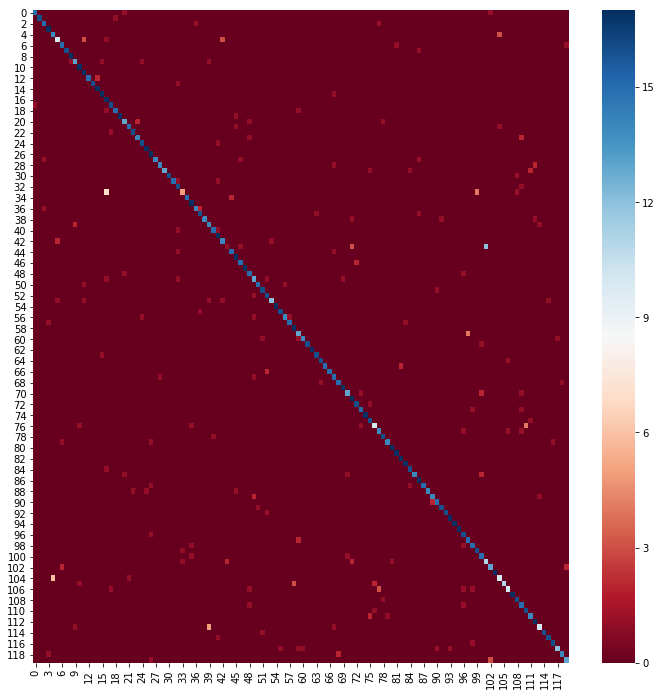

In [12]:
plt.figure(figsize=(12,12))
sns.heatmap(data = conf,cmap='RdBu')

This Method without too much epochs gave us better accuracy then running with fixed sized images.
We think that if our dataset was completely unseen (ecxeption is already trained on this data with fixed size images) we could gain even more improvments working like that

Another idea could be instead of augmenting all images to different sizes and working with them, just divide the data by sizes and train each time on larger images, but for that idea to work our dataset should be big enough to support that division

## A couple of tries with other ML algorithms

In [65]:
from sklearn.svm import SVC


svm_model_linear = SVC(C=1.0, kernel='poly', degree=7, gamma='auto').fit(trainFeatures, MLTrain_generator.classes) 

ClassPredictions = svm_model_linear.predict(validFeatures)
#ClasProba = svm_model_linear.predict_proba(validFeatures)

In [66]:
print('Validation LogLoss {}'.format(log_loss(MLTest_generator.classes, ClasProba)))
print(classification_report(MLTest_generator.classes, ClassPredictions, target_names=target_names))

Validation LogLoss 1.460287614811982
                                precision    recall  f1-score   support

                 affenpinscher       0.00      0.00      0.00        17
                  afghan_hound       0.00      0.00      0.00        17
           african_hunting_dog       0.00      0.00      0.00        17
                      airedale       0.00      0.00      0.00        17
american_staffordshire_terrier       0.00      0.00      0.00        17
                   appenzeller       0.00      0.00      0.00        17
            australian_terrier       0.00      0.00      0.00        17
                       basenji       0.00      0.00      0.00        17
                        basset       0.00      0.00      0.00        17
                        beagle       0.00      0.00      0.00        17
            bedlington_terrier       0.00      0.00      0.00        17
          bernese_mountain_dog       0.00      0.00      0.00        17
       black-and-tan_coonh

C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\doron\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(trainFeatures, MLTrain_generator.classes)

ClassPredictions = knn.predict(validFeatures)
ClasProba = knn.predict_proba(validFeatures)

In [60]:
ClassPredictions = knn.predict(validFeatures)
ClasProba = knn.predict_proba(validFeatures)

print('LogLoss {}'.format(log_loss(MLTest_generator.classes, ClasProba)))
print(classification_report(MLTest_generator.classes, ClassPredictions, target_names=target_names))

Validation LogLoss 1.460287614811982
                                precision    recall  f1-score   support

                 affenpinscher       1.00      0.88      0.94        17
                  afghan_hound       0.94      0.94      0.94        17
           african_hunting_dog       1.00      0.94      0.97        17
                      airedale       0.81      1.00      0.89        17
american_staffordshire_terrier       0.69      0.65      0.67        17
                   appenzeller       0.75      0.53      0.62        17
            australian_terrier       0.70      0.94      0.80        17
                       basenji       1.00      1.00      1.00        17
                        basset       0.85      1.00      0.92        17
                        beagle       0.76      0.76      0.76        17
            bedlington_terrier       0.89      1.00      0.94        17
          bernese_mountain_dog       0.74      1.00      0.85        17
       black-and-tan_coonh